In [1]:
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

ROOT_DIR = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
TRAIN_DIR = os.path.join(ROOT_DIR, "train")
VALID_DIR = os.path.join(ROOT_DIR, "valid")
TEST_DIR = "/kaggle/input/new-plant-diseases-dataset/test"

# Classes
classes = os.listdir(TRAIN_DIR)
print(f"Detected classes: {classes}")
print(f"Total classes: {len(classes)}")


Detected classes: ['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Lea

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [5]:
train_dataset = ImageFolder(TRAIN_DIR, transform=train_transforms)
valid_dataset = ImageFolder(VALID_DIR, transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool=False):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2) if pool else nn.Identity()
    
    def forward(self, x):
        return self.pool(self.block(x))

class PlantCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.layer1 = ConvBlock(in_channels, 64, pool=True)
        self.layer2 = ConvBlock(64, 128, pool=True)
        self.layer3 = ConvBlock(128, 256, pool=True)
        self.layer4 = ConvBlock(256, 512, pool=True)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = PlantCNN(3, len(train_dataset.classes)).to(device)


In [7]:
import torch.optim as optim

def accuracy(preds, labels):
    _, pred_classes = torch.max(preds, 1)
    return torch.sum(pred_classes == labels).item() / labels.size(0)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += accuracy(outputs, labels)
        
    return total_loss / len(loader), total_acc / len(loader)

def validate(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            total_acc += accuracy(outputs, labels)
            
    return total_loss / len(loader), total_acc / len(loader)


In [10]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += accuracy(outputs, labels)
        
    return total_loss / len(loader), total_acc / len(loader)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, valid_loader, criterion)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1/5: Train Loss=0.6555, Train Acc=0.8010, Val Loss=0.3024, Val Acc=0.9085


Epoch 2/5: Train Loss=0.3389, Train Acc=0.8939, Val Loss=0.1890, Val Acc=0.9393


Epoch 3/5: Train Loss=0.2335, Train Acc=0.9259, Val Loss=0.1529, Val Acc=0.9517


Epoch 4/5: Train Loss=0.1780, Train Acc=0.9433, Val Loss=0.1922, Val Acc=0.9377


Epoch 5/5: Train Loss=0.1427, Train Acc=0.9550, Val Loss=0.1676, Val Acc=0.9507


In [12]:
# Save the entire model (architecture + weights)
torch.save(model, "/kaggle/working/plant_disease_cnn.pth")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [28]:
import torch
from torchvision import transforms
from PIL import Image
import os
import torch.nn as nn
import torch.nn.functional as F

# --- 1. Model Architecture (Must be redefined to load the weights) ---
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool=False):
        super().__init__()
        # ... (rest of ConvBlock definition)
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(2) if pool else nn.Identity()
    
    def forward(self, x):
        return self.pool(self.block(x))

class PlantCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # ... (rest of PlantCNN definition)
        self.layer1 = ConvBlock(in_channels, 64, pool=True)
        self.layer2 = ConvBlock(128, 256, pool=True)
        self.layer3 = ConvBlock(256, 512, pool=True)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x

# --- 2. Setup Device and Paths ---
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/kaggle/working/plant_disease_cnn.pth"
IMAGE_PATH = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG"

# --- 3. Get Class Names ---
ROOT_DIR = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
TRAIN_DIR = os.path.join(ROOT_DIR, "train")
CLASSES = sorted(os.listdir(TRAIN_DIR)) # Sorting ensures consistent order

# --- 4. Load the Model with weights_only=False ---
# THIS IS THE FIX
model = torch.load(MODEL_PATH, map_location=device, weights_only=False) 
model.eval() # Set the model to evaluation mode
print(f"✅ Model loaded successfully from {MODEL_PATH} to {device}.")

# --- 5. Image Preprocessing (Validation/Test Transforms) ---
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 6. Prediction Function ---
def predict_image(model, image_path, transforms, class_names):
    # Load the image
    img = Image.open(image_path)
    
    # Apply transformations and add a batch dimension (C, H, W) -> (1, C, H, W)
    img_tensor = transforms(img).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(img_tensor)
    
    # Get the class index and probability
    probabilities = torch.softmax(output, dim=1)
    predicted_prob, predicted_idx = torch.max(probabilities, 1)
    
    # Map index to class name
    predicted_class = class_names[predicted_idx.item()]
    
    print("\n--- Prediction Result ---")
    print(f"Image Path: {image_path}")
    print(f"Predicted Class Index: {predicted_idx.item()}")
    print(f"Predicted Class Name: {predicted_class}")
    print(f"Confidence: {predicted_prob.item()*100:.2f}%")

# --- 7. Run Prediction ---
predict_image(model, IMAGE_PATH, test_transforms, CLASSES)

✅ Model loaded successfully from /kaggle/working/plant_disease_cnn.pth to cuda.

--- Prediction Result ---
Image Path: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG
Predicted Class Index: 0
Predicted Class Name: Apple___Apple_scab
Confidence: 86.57%


In [1]:
import os

data_root = "/kaggle/input/wheat-plant-diseases/data"

def explore_dataset_structure(root_dir):
    for split in ["train", "valid", "test"]:
        split_dir = os.path.join(root_dir, split)
        print(f"\n📁 {split_dir}")
        if not os.path.exists(split_dir):
            print("❌ Directory not found!")
            continue
        
        for class_name in sorted(os.listdir(split_dir)):
            class_path = os.path.join(split_dir, class_name)
            if os.path.isdir(class_path):
                num_files = sum(len(files) for _, _, files in os.walk(class_path))
                print(f"  ├── {class_name}  ({num_files} images)")
            else:
                print(f"  ⚠️ {class_name} is not a folder")
                
explore_dataset_structure(data_root)



📁 /kaggle/input/wheat-plant-diseases/data/train
  ├── Aphid  (903 images)
  ├── Black Rust  (576 images)
  ├── Blast  (647 images)
  ├── Brown Rust  (1271 images)
  ├── Common Root Rot  (614 images)
  ├── Fusarium Head Blight  (611 images)
  ├── Healthy  (1000 images)
  ├── Leaf Blight  (842 images)
  ├── Mildew  (1081 images)
  ├── Mite  (800 images)
  ├── Septoria  (1144 images)
  ├── Smut  (1310 images)
  ├── Stem fly  (234 images)
  ├── Tan spot  (770 images)
  ├── Yellow Rust  (1301 images)

📁 /kaggle/input/wheat-plant-diseases/data/valid
  ├── aphid_valid  (20 images)
  ├── black_rust_valid  (20 images)
  ├── blast_test_valid  (20 images)
  ├── brown_rust_valid  (20 images)
  ├── common_root_rot_valid  (20 images)
  ├── fusarium_head_blight_valid  (20 images)
  ├── healthy_valid  (20 images)
  ├── leaf_blight_valid  (20 images)
  ├── mildew_valid  (20 images)
  ├── mite_valid  (20 images)
  ├── septoria_valid  (20 images)
  ├── smut_valid  (20 images)
  ├── stem_fly_valid  (20 i

In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dir = "/kaggle/input/wheat-plant-diseases/data/train"
valid_dir = "/kaggle/input/wheat-plant-diseases/data/valid"
test_dir  = "/kaggle/input/wheat-plant-diseases/data/test"

transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

transform_val_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

def load_valid_dataset(base_dir, suffix_to_remove, transform):
    """Loads dataset with renamed class labels virtually (not on disk)"""
    from torchvision.datasets import ImageFolder
    import tempfile, shutil

    tmp_dir = tempfile.mkdtemp()
    for folder in os.listdir(base_dir):
        src = os.path.join(base_dir, folder)
        if not os.path.isdir(src):
            continue
        new_name = folder.replace(suffix_to_remove, "").replace("__", "_").strip().capitalize()
        dst = os.path.join(tmp_dir, new_name)
        os.symlink(src, dst)  # symbolic link instead of copy
    return datasets.ImageFolder(tmp_dir, transform=transform)

# ✅ Load datasets safely
train_data = datasets.ImageFolder(train_dir, transform=transform_train)
val_data   = load_valid_dataset(valid_dir, "_valid", transform_val_test)
test_data  = load_valid_dataset(test_dir, "_test", transform_val_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"✅ Classes ({len(train_data.classes)}): {train_data.classes}")


✅ Classes (15): ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']


In [4]:
class CNN_NeuralNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_NeuralNet, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, xb):
        return self.network(xb)


In [6]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_corrects = 0.0, 0
    total = len(loader.dataset)

    # 🔥 tqdm progress bar for batches
    loop = tqdm(loader, total=len(loader), desc="Training", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # update bar dynamically
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    return epoch_loss, epoch_acc.item()


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    total = len(loader.dataset)

    with torch.no_grad():
        loop = tqdm(loader, total=len(loader), desc="Validating", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    return epoch_loss, epoch_acc.item()


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 15

for epoch in range(num_epochs):
    print(f"\n🔹 Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, valid_loader, criterion, device)

    print(f"✅ Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")



🔹 Epoch 1/15


✅ Epoch 1/15: Train Loss=0.9061, Train Acc=0.7015, Val Loss=1.8253, Val Acc=0.5800

🔹 Epoch 2/15


✅ Epoch 2/15: Train Loss=0.7836, Train Acc=0.7377, Val Loss=1.5890, Val Acc=0.7167

🔹 Epoch 3/15


✅ Epoch 3/15: Train Loss=0.7085, Train Acc=0.7660, Val Loss=1.9185, Val Acc=0.7100

🔹 Epoch 4/15


✅ Epoch 4/15: Train Loss=0.6338, Train Acc=0.7925, Val Loss=1.7385, Val Acc=0.7300

🔹 Epoch 5/15


✅ Epoch 5/15: Train Loss=0.5791, Train Acc=0.8072, Val Loss=1.7204, Val Acc=0.7833

🔹 Epoch 6/15


✅ Epoch 6/15: Train Loss=0.5237, Train Acc=0.8269, Val Loss=1.5090, Val Acc=0.8067

🔹 Epoch 7/15


✅ Epoch 7/15: Train Loss=0.4797, Train Acc=0.8417, Val Loss=1.6661, Val Acc=0.8100

🔹 Epoch 8/15


✅ Epoch 8/15: Train Loss=0.4434, Train Acc=0.8545, Val Loss=1.5465, Val Acc=0.7833

🔹 Epoch 9/15


✅ Epoch 9/15: Train Loss=0.3984, Train Acc=0.8674, Val Loss=1.7039, Val Acc=0.8433

🔹 Epoch 10/15


✅ Epoch 10/15: Train Loss=0.3756, Train Acc=0.8726, Val Loss=2.2008, Val Acc=0.8567

🔹 Epoch 11/15


✅ Epoch 11/15: Train Loss=0.3693, Train Acc=0.8742, Val Loss=2.4985, Val Acc=0.8600

🔹 Epoch 12/15


✅ Epoch 12/15: Train Loss=0.3259, Train Acc=0.8926, Val Loss=2.2845, Val Acc=0.8733

🔹 Epoch 13/15


✅ Epoch 13/15: Train Loss=0.3063, Train Acc=0.8989, Val Loss=2.0761, Val Acc=0.8533

🔹 Epoch 14/15


✅ Epoch 14/15: Train Loss=0.2804, Train Acc=0.9013, Val Loss=2.2478, Val Acc=0.8700

🔹 Epoch 15/15


✅ Epoch 15/15: Train Loss=0.3065, Train Acc=0.8994, Val Loss=1.9241, Val Acc=0.8933


In [21]:
import torch

# Assume 'model' is your trained CNN_NeuralNet
save_path = "/kaggle/working/wheat_stem_model_final.pth"

# Save entire model
torch.save(model, save_path)
print(f"✅ Model saved at {save_path}")


✅ Model saved at /kaggle/working/wheat_stem_model_final.pth


Classes: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
✅ Model loaded on cuda
✅ Predicted: Brown Rust (confidence: 51.62%)


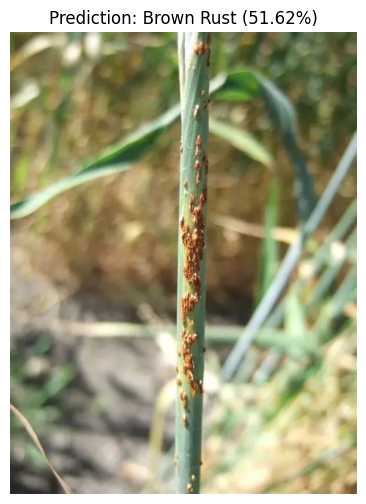


Top 3 Predictions:
1. Brown Rust: 51.62%
2. Mildew: 33.44%
3. Yellow Rust: 12.72%


In [4]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Paths
model_path = "/kaggle/input/modeltrtained/wheat_stem_model_final.pth"
image_path = "/kaggle/input/hvihvhviu/OIP (2).webp"
train_dir = "/kaggle/input/wheat-plant-diseases/data/train"

# Load classes from train (original names, assuming order matches)
train_data = ImageFolder(train_dir)  # No transform needed for classes
classes = train_data.classes
print(f"Classes: {classes}")

# Model definition (same as before) - define for reference, but not needed for full model load
class CNN_NeuralNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_NeuralNet, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, xb):
        return self.network(xb)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Fix: Load with weights_only=False (safe for trusted local files like Kaggle outputs)
model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()
print(f"✅ Model loaded on {device}")

# Transform (same as val/test)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load and preprocess image
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim

# Predict
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_idx = torch.argmax(output[0]).item()
    predicted_class = classes[predicted_idx]
    confidence = probabilities[predicted_idx].item() * 100

print(f"✅ Predicted: {predicted_class} (confidence: {confidence:.2f}%)")

# Optional: Visualize image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()

# Top 3 predictions
top3_prob, top3_indices = torch.topk(probabilities, 3)
print("\nTop 3 Predictions:")
for i in range(3):
    class_name = classes[top3_indices[i]]
    prob = top3_prob[i].item() * 100
    print(f"{i+1}. {class_name}: {prob:.2f}%")